In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
warnings.filterwarnings('ignore')

**Importacion de datos procesados**

Importamos los datos procesados en el analisis EDA

In [14]:
df = pd.read_parquet("data/dataset_procesada.parquet", engine="pyarrow")
df

,exportaciones,importaciones,precio_petroleo,igae,pib,consumo_final,inversion_total,tasa_inflacion
fecha,,,,,,,,
2008-10-01,-0.454482,-0.299724,-4.956194,0.037897,0.038064,0.581546,0.414413,-0.060587
2009-01-01,-1.812458,-0.796024,-1.256884,-0.886494,-0.886777,-0.798865,-0.811319,-1.995298
2009-04-01,0.356706,0.603206,1.470491,1.032076,1.032046,0.188213,0.485071,4.119722
2009-07-01,0.512052,0.556132,0.794157,-0.273556,-0.273605,-0.096622,-0.070220,-1.670576
2009-10-01,0.117188,0.069532,0.725736,0.123238,0.123502,0.652331,0.510964,-0.177565
...,...,...,...,...,...,...,...,...
2023-10-01,-0.949204,-0.144119,-0.283497,1.441632,1.441919,1.999727,0.736056,-0.302286
2024-01-01,-1.801562,-1.529920,-0.049535,-1.893434,-1.893470,-1.957061,-1.796246,0.082974
2024-04-01,1.673592,0.960185,0.375641,0.491718,0.491684,-0.176902,1.100735,0.528649


**Creación de funciones generales**

Crearemos funciones generales que seran usadas en cada variante que se crearan, esto con el fin de evitar escribir codigo en cada variante

In [15]:
def buscar_mejor_arima_auto(y, exog=None, max_p=5, max_d=2, max_q=5,
                        seasonal=True, m=12, trace=False, stepwise=True,
                        error_action='ignore', suppress_warnings=True,
                        n_fits=10): # n_fits para búsqueda paralela si stepwise=False
    
    if suppress_warnings:
        warnings.filterwarnings("ignore")
    
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_data = y
    else:
        y_data = np.asarray(y)
    
    if exog is not None:
        if isinstance(exog, (pd.Series, pd.DataFrame)):
            exog_data = exog
        else:
            exog_data = np.asarray(exog)
    else:
        exog_data = None

    modelo_optimo = pm.auto_arima(y_data,
                                exog=exog_data,
                                start_p=1, max_p=max_p,
                                start_d=0, max_d=max_d,
                                start_q=1, max_q=max_q,
                                seasonal=seasonal,
                                m=m, # Periodo estacional
                                start_P=1, max_P=2, # Rangos para la parte estacional
                                start_D=0, max_D=1,
                                start_Q=1, max_Q=2,
                                trace=trace,          # Muestra el progreso
                                error_action=error_action,
                                suppress_warnings=suppress_warnings,
                                stepwise=stepwise,    # Utiliza un algoritmo de búsqueda más eficiente
                                n_jobs=-1 if not stepwise else 1
                                )
    
    if suppress_warnings:
        warnings.filterwarnings("default")

    return modelo_optimo

In [16]:
def entrenar_arimax(y_train, exog_train, order, seasonal_order=(0,0,0,0),guardarModelo=False):

    model = ARIMA(y_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    if(guardarModelo==True):
        joblib.dump(model_fit, 'models/arimax_model.joblib')
        print("Modelo guardado exitosamente en 'models/arimax_model.joblib'")
    # Predicciones en el mismo rango de entrenamiento
    y_train_pred = model_fit.predict(start=y_train.index[0], end=y_train.index[-1], exog=exog_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    print("\n Resumen del modelo ARIMAX ENTRENADO:")
    print("MAE (train):", mae_train)
    print("RMSE (train):", rmse_train)

    return model_fit

In [17]:
def predecir_arimax(modelo_fit, steps, exog_forecast=None):
    forecast = modelo_fit.forecast(steps=steps, exog=exog_forecast)
    return forecast

In [18]:
def evaluar_modelo(y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

In [19]:
def diagnosticos_modelo(modelo_fit):
    # Test de Ljung-Box para autocorrelación en residuos
    residuos = modelo_fit.resid
    ljung_box = acorr_ljungbox(residuos, lags=10, return_df=True)
    
    # Estadísticas del modelo
    aic = modelo_fit.aic
    bic = modelo_fit.bic
    
    diagnosticos = {
        'AIC': aic,
        'BIC': bic,
        'Ljung_Box_pvalue': ljung_box['lb_pvalue'].min(),
        'Log_Likelihood': modelo_fit.llf
    }
    
    return diagnosticos

In [20]:
def graficar_resultados(y_train,y_test, y_pred,fechas_train, fechas_test):
    scaler = joblib.load('data/scaler_pib.joblib')
    y_train_array = np.array(y_train)
    y_test_array = np.array(y_test)
    y_pred_array = np.array(y_pred)
    y_train_desnormalizado = scaler.inverse_transform(y_train_array.reshape(-1, 1)).flatten()
    y_test_desnormalizado = scaler.inverse_transform(y_test_array.reshape(-1, 1)).flatten()
    y_pred_desnormalizado = scaler.inverse_transform(y_pred_array.reshape(-1, 1)).flatten()
    # Visualizar
    plt.figure(figsize=(15, 6), dpi=80,facecolor="#F2F2F2")
    plt.plot(fechas_test, y_test_desnormalizado.flatten(), marker='.', label="Valor real")
    plt.plot(fechas_test, y_pred_desnormalizado.flatten(), 'r', marker='.', label="Predicción")
    plt.plot(fechas_train, y_train_desnormalizado.flatten(), 'g', marker='.', label="Histórico")
    plt.ylabel('PIB de Bolivia')
    plt.xlabel('Fecha')
    plt.legend()
    
    # Quitar las líneas de contorno y fondo
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().patch.set_facecolor('#F2F2F2')
    plt.gca().set_facecolor('#F2F2F2')
    plt.show()

In [21]:
def generarModelo(df, todo=False,guardarModelo=False):
    
    y = df['pib']  # Variable objetivo
    exog = df.drop('pib', axis=1)  # Variables exógenas
    y_train = None
    y_test = None
    exog_train = None
    exog_test = None
    predicciones = None
    metricas = None
    modelo_final = None
    if(todo==False):
        test_start = "2023-01-01"

        y_train = y.loc[:test_start].iloc[:-1]
        y_test = y.loc[test_start:]

        exog_train = exog.loc[:test_start].iloc[:-1]
        exog_test = exog.loc[test_start:]
    else:
        y_train = y
        exog_train = exog
    
    print("Buscando los mejores parámetros ARIMAX con auto_arima...")

    best_sarimax_model_pm = buscar_mejor_arima_auto(
        y=y_train, 
        exog=exog_train, 
        max_p=5, max_d=2, max_q=5,
        seasonal=True, m=4,
        trace=True, 
        stepwise=True,
        suppress_warnings=True
    )

    # Extraer los parámetros del mejor modelo encontrado por pmdarima
    best_order = best_sarimax_model_pm.order
    best_seasonal_order = best_sarimax_model_pm.seasonal_order
    
    print(f"\nMejores parámetros no estacionales: {best_order}")
    print(f"Mejores parámetros estacionales: {best_seasonal_order}")
    print(f"Mejor AIC (pmdarima): {best_sarimax_model_pm.aic():.4f}")

    modelo_final = entrenar_arimax(y_train, exog_train, best_order, best_seasonal_order,guardarModelo)
    
    if(todo==False):
        n_steps = len(y_test)
        predicciones = predecir_arimax(modelo_final, n_steps, exog_test)
    
        predicciones.index = y_test.index

        metricas = evaluar_modelo(y_test, predicciones)
    
        print("\n=== MÉTRICAS DE EVALUACIÓN ===")
        for metrica, valor in metricas.items():
            print(f"{metrica}: {valor:.4f}")
    
    print("\n=== DIAGNÓSTICOS DEL MODELO ===")
    diagnosticos = diagnosticos_modelo(modelo_final)
    
    for diagnostico, valor in diagnosticos.items():
        print(f"{diagnostico}: {valor:.4f}")
    
    print("\n=== RESUMEN DEL MODELO ===")
    print(modelo_final.summary())
    if(todo==False):
        graficar_resultados(y_train,y_test, predicciones,y_train.index, y_test.index)
    
    return modelo_final, predicciones, metricas

**Generación de modelos**

En esta sección generaremos los modelos, cada uno variando en sus variables exogenas para ver el comportamiento y poder elegir el mejor modelo

**Modelo: M1**

En este modelo usaremos las variables: 
- exportaciones
- importaciones 
- precio del petroleo 
- consumo final 
- inversion total 
- tasa de inflacion

Buscando los mejores parámetros ARIMAX con auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=165.013, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=115.997, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=120.157, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=163.016, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=152.294, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=112.710, Time=0.11 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=111.111, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=109.111, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=133.752, Time=0.06 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=116.797, Time=0.37 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=124.939, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=113.040, Time=0.41 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=110.176, Time=0.1

e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\reshape\util.py:60: DeprecationWarning: `product` i


 Resumen del modelo ARIMAX ENTRENADO:
MAE (train): 0.1144987505416134
RMSE (train): 0.2053967944089737

=== MÉTRICAS DE EVALUACIÓN ===
MAE: 0.0813
MSE: 0.0095
RMSE: 0.0976
MAPE: 14.6710

=== DIAGNÓSTICOS DEL MODELO ===
AIC: -57.6648
BIC: -31.1052
Ljung_Box_pvalue: 0.0164
Log_Likelihood: 41.8324

=== RESUMEN DEL MODELO ===
                                    SARIMAX Results                                    
Dep. Variable:                             pib   No. Observations:                   57
Model:             ARIMA(2, 0, 1)x(1, 0, 1, 4)   Log Likelihood                  41.832
Date:                         Wed, 08 Oct 2025   AIC                            -57.665
Time:                                 21:21:03   BIC                            -31.105
Sample:                             10-01-2008   HQIC                           -47.343
                                  - 10-01-2022                                         
Covariance Type:                           opg             

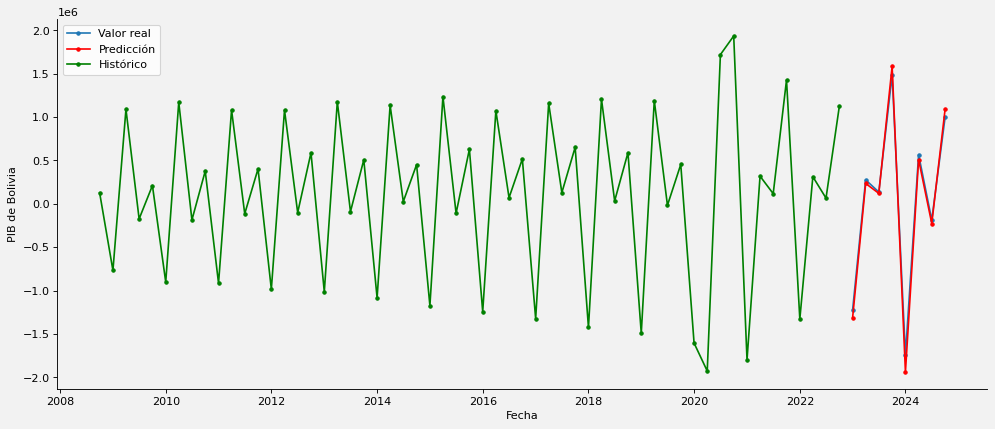

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x266cebbceb0>,
 fecha
 2023-01-01   -1.448073
 2023-04-01    0.148567
 2023-07-01    0.030679
 2023-10-01    1.542678
 2024-01-01   -2.096337
 2024-04-01    0.432233
 2024-07-01   -0.328429
 2024-10-01    1.029113
 Name: predicted_mean, dtype: float64,
 {'MAE': 0.08125694197488484,
  'MSE': 0.009517394497521004,
  'RMSE': 0.09755713452905945,
  'MAPE': 14.671009520369834})

In [22]:
df1 = df.drop('igae', axis=1)
generarModelo(df1)

**Modelo: M2**

En este modelo usaremos las variables: 
- exportaciones
- precio del petroleo  
- inversion total 
- tasa de inflacion

Buscando los mejores parámetros ARIMAX con auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=165.013, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=115.997, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=120.157, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=163.016, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=152.294, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=112.710, Time=0.10 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=111.111, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=109.111, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=133.752, Time=0.07 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=116.797, Time=0.36 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=124.939, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=113.040, Time=0.44 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=110.176, Time=0.1

e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\reshape\util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumproduct` is depreca


 Resumen del modelo ARIMAX ENTRENADO:
MAE (train): 0.21881169907245998
RMSE (train): 0.3397162272787108

=== MÉTRICAS DE EVALUACIÓN ===
MAE: 0.2456
MSE: 0.0824
RMSE: 0.2871
MAPE: 43.2547

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 61.5495
BIC: 84.0231
Ljung_Box_pvalue: 0.9526
Log_Likelihood: -19.7748

=== RESUMEN DEL MODELO ===
                                    SARIMAX Results                                    
Dep. Variable:                             pib   No. Observations:                   57
Model:             ARIMA(2, 0, 1)x(1, 0, 1, 4)   Log Likelihood                 -19.775
Date:                         Wed, 08 Oct 2025   AIC                             61.550
Time:                                 21:21:16   BIC                             84.023
Sample:                             10-01-2008   HQIC                            70.284
                                  - 10-01-2022                                         
Covariance Type:                           opg             

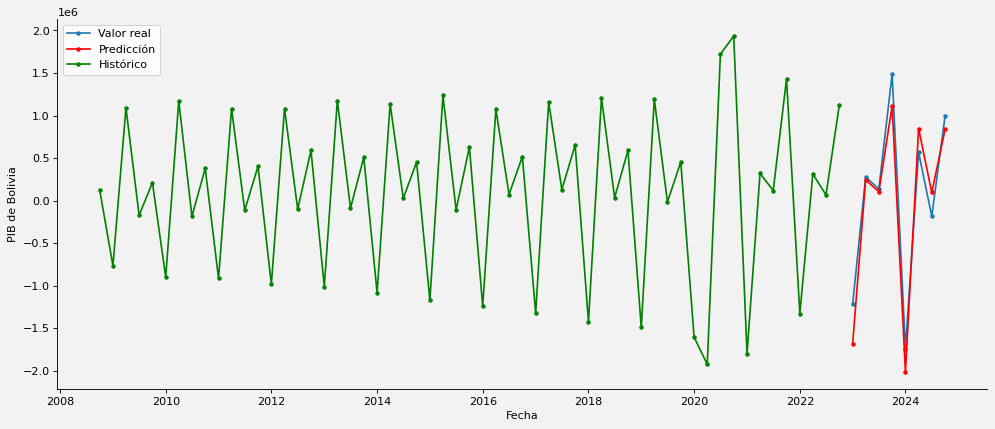

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x266d0dc1240>,
 fecha
 2023-01-01   -1.835907
 2023-04-01    0.156825
 2023-07-01    0.012450
 2023-10-01    1.052631
 2024-01-01   -2.176479
 2024-04-01    0.780415
 2024-07-01    0.003440
 2024-10-01    0.770273
 Name: predicted_mean, dtype: float64,
 {'MAE': 0.24557581437746318,
  'MSE': 0.08244878284976612,
  'RMSE': 0.2871389608704575,
  'MAPE': 43.25471531509131})

In [23]:
df2 = df.drop(['igae', 'importaciones', 'consumo_final'], axis=1)
generarModelo(df2)

**Modelo: M3**

En este modelo usaremos las variables: 
- importaciones 
- precio del petroleo 
- consumo final 
- tasa de inflacion

Buscando los mejores parámetros ARIMAX con auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=165.013, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=115.997, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=120.157, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=163.016, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=152.294, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=112.710, Time=0.11 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=111.111, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=109.111, Time=0.33 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=133.752, Time=0.06 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=116.797, Time=0.37 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=124.939, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=113.040, Time=0.38 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=110.176, Time=0.1

e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\reshape\util.py:60: DeprecationWarning: `product` i


 Resumen del modelo ARIMAX ENTRENADO:
MAE (train): 0.10285887826532217
RMSE (train): 0.1822456305204109

=== MÉTRICAS DE EVALUACIÓN ===
MAE: 0.0674
MSE: 0.0056
RMSE: 0.0747
MAPE: 19.6381

=== DIAGNÓSTICOS DEL MODELO ===
AIC: -67.0448
BIC: -44.5713
Ljung_Box_pvalue: 0.1772
Log_Likelihood: 44.5224

=== RESUMEN DEL MODELO ===
                                    SARIMAX Results                                    
Dep. Variable:                             pib   No. Observations:                   57
Model:             ARIMA(2, 0, 1)x(1, 0, 1, 4)   Log Likelihood                  44.522
Date:                         Wed, 08 Oct 2025   AIC                            -67.045
Time:                                 21:21:29   BIC                            -44.571
Sample:                             10-01-2008   HQIC                           -58.311
                                  - 10-01-2022                                         
Covariance Type:                           opg            

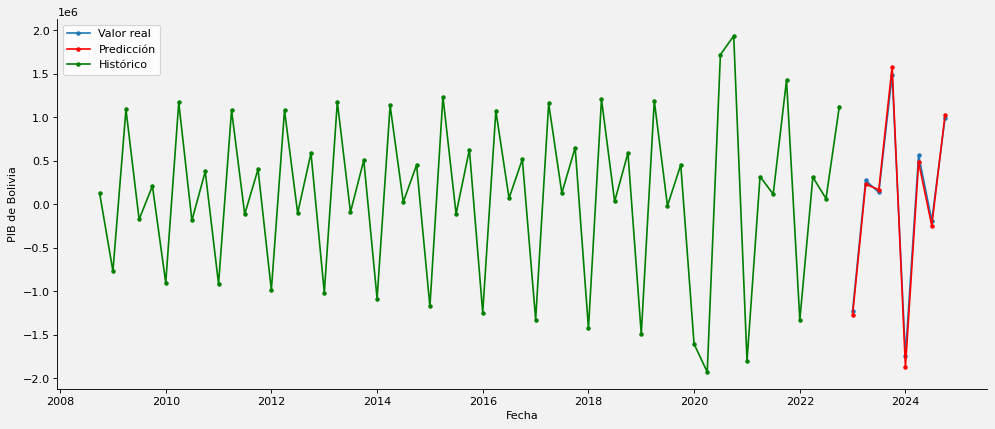

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x266cfcdc3a0>,
 fecha
 2023-01-01   -1.402478
 2023-04-01    0.143602
 2023-07-01    0.080211
 2023-10-01    1.540648
 2024-01-01   -2.024237
 2024-04-01    0.405915
 2024-07-01   -0.346840
 2024-10-01    0.969878
 Name: predicted_mean, dtype: float64,
 {'MAE': 0.06736159748745302,
  'MSE': 0.005582648942906963,
  'RMSE': 0.07471712616868346,
  'MAPE': 19.638111104129926})

In [24]:
df3 = df.drop(['igae', 'exportaciones', 'inversion_total'], axis=1)
generarModelo(df3)

**Modelo: M4**

En este modelo usaremos las variables: 
- precio del petroleo 
- consumo final 
- tasa de inflacion

Buscando los mejores parámetros ARIMAX con auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=165.013, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=115.997, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=120.157, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=163.016, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=152.294, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=112.710, Time=0.12 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=111.111, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=109.111, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=133.752, Time=0.06 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=116.797, Time=0.33 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=124.939, Time=0.08 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=113.040, Time=0.39 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=110.176, Time=0.1

e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\reshape\util.py:60: DeprecationWarning: `product` i


 Resumen del modelo ARIMAX ENTRENADO:
MAE (train): 0.10376474955631941
RMSE (train): 0.1838488215804185

=== MÉTRICAS DE EVALUACIÓN ===
MAE: 0.0577
MSE: 0.0045
RMSE: 0.0670
MAPE: 16.5871

=== DIAGNÓSTICOS DEL MODELO ===
AIC: -68.8948
BIC: -48.4643
Ljung_Box_pvalue: 0.1245
Log_Likelihood: 44.4474

=== RESUMEN DEL MODELO ===
                                    SARIMAX Results                                    
Dep. Variable:                             pib   No. Observations:                   57
Model:             ARIMA(2, 0, 1)x(1, 0, 1, 4)   Log Likelihood                  44.447
Date:                         Wed, 08 Oct 2025   AIC                            -68.895
Time:                                 21:21:43   BIC                            -48.464
Sample:                             10-01-2008   HQIC                           -60.955
                                  - 10-01-2022                                         
Covariance Type:                           opg            

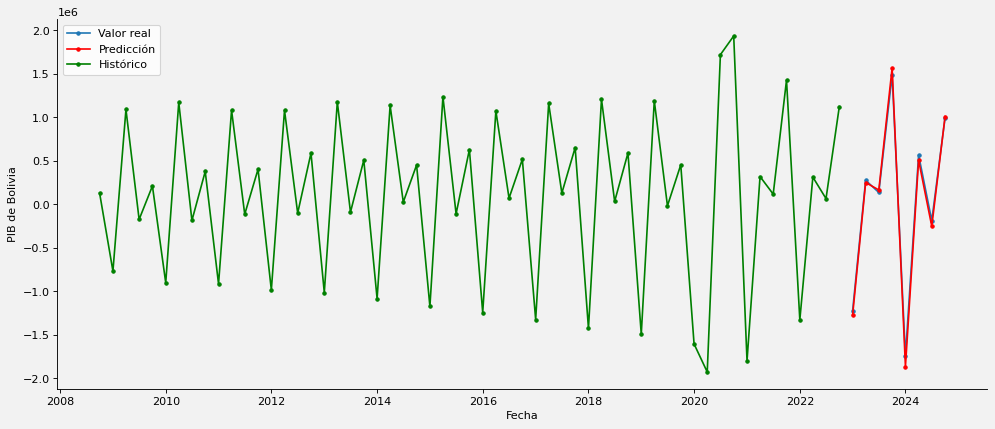

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x266cfcdd8d0>,
 fecha
 2023-01-01   -1.407702
 2023-04-01    0.164638
 2023-07-01    0.076445
 2023-10-01    1.524281
 2024-01-01   -2.020221
 2024-04-01    0.429267
 2024-07-01   -0.354633
 2024-10-01    0.948463
 Name: predicted_mean, dtype: float64,
 {'MAE': 0.05774463032397919,
  'MSE': 0.0044837693620751445,
  'RMSE': 0.06696095401108876,
  'MAPE': 16.587130651351227})

In [25]:
df4 = df.drop(['igae', 'exportaciones','importaciones', 'inversion_total'], axis=1)
generarModelo(df4)

**Modelo: M5**

En este modelo usaremos las variables: 
- importaciones 
- precio del petroleo
- tasa de inflacion

Buscando los mejores parámetros ARIMAX con auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=165.013, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=115.997, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=120.157, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=163.016, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=152.294, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=112.710, Time=0.10 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=111.111, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=109.111, Time=0.31 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=133.752, Time=0.06 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=116.797, Time=0.34 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=124.939, Time=0.07 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=113.040, Time=0.41 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=110.176, Time=0.1

e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\reshape\util.py:60: DeprecationWarning: `p


 Resumen del modelo ARIMAX ENTRENADO:
MAE (train): 0.2666797070594253
RMSE (train): 0.45785206599481715

=== MÉTRICAS DE EVALUACIÓN ===
MAE: 0.3239
MSE: 0.1351
RMSE: 0.3675
MAPE: 140.1545

=== DIAGNÓSTICOS DEL MODELO ===
AIC: 93.4370
BIC: 113.8675
Ljung_Box_pvalue: 0.7947
Log_Likelihood: -36.7185

=== RESUMEN DEL MODELO ===
                                    SARIMAX Results                                    
Dep. Variable:                             pib   No. Observations:                   57
Model:             ARIMA(2, 0, 1)x(1, 0, 1, 4)   Log Likelihood                 -36.718
Date:                         Wed, 08 Oct 2025   AIC                             93.437
Time:                                 21:21:56   BIC                            113.867
Sample:                             10-01-2008   HQIC                           101.377
                                  - 10-01-2022                                         
Covariance Type:                           opg           

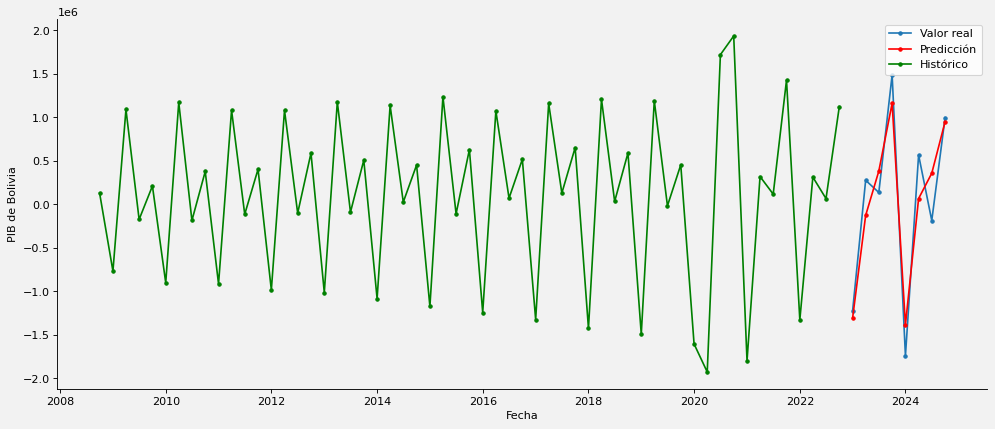

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x266cea7b550>,
 fecha
 2023-01-01   -1.441980
 2023-04-01   -0.226258
 2023-07-01    0.300407
 2023-10-01    1.104911
 2024-01-01   -1.525189
 2024-04-01   -0.025544
 2024-07-01    0.274544
 2024-10-01    0.885596
 Name: predicted_mean, dtype: float64,
 {'MAE': 0.3238874708564161,
  'MSE': 0.13507627001172542,
  'RMSE': 0.3675272371018581,
  'MAPE': 140.15452637384976})

In [26]:
df5 = df.drop(['igae', 'exportaciones','consumo_final', 'inversion_total'], axis=1)
generarModelo(df5)

**Conclusión**

En base a los valores obtenidos en cada modelo generado, se puede apreciar y seleccionar al modelo **M4** como el mejor modelo de todos

**Modelo entrenado con todos los datos y guardado automatico**

Para futuras investigaciones, se esta guardando el modelo **M4** entrenado con todos los datos disponibles en la base de datos para que pueda ser utilizado en predicciones

In [27]:
df4 = df.drop(['igae', 'exportaciones','importaciones', 'inversion_total'], axis=1)
generarModelo(df4,True,True)

Buscando los mejores parámetros ARIMAX con auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=188.462, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=125.587, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=131.851, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=186.462, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=171.786, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=120.500, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=118.100, Time=0.27 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=116.101, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=147.788, Time=0.07 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=118.100, Time=0.25 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=141.509, Time=0.07 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=119.882, Time=0.44 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=118.009, Time=0.16

e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Modelo guardado exitosamente en 'models/arimax_model.joblib'

 Resumen del modelo ARIMAX ENTRENADO:
MAE (train): 0.10194541473719719
RMSE (train): 0.1728065704812425

=== DIAGNÓSTICOS DEL MODELO ===
AIC: -81.5363
BIC: -59.7924
Ljung_Box_pvalue: 0.1950
Log_Likelihood: 50.7682

=== RESUMEN DEL MODELO ===
                                    SARIMAX Results                                    
Dep. Variable:                             pib   No. Observations:                   65
Model:             ARIMA(2, 0, 1)x(1, 0, 1, 4)   Log Likelihood                  50.768
Date:                         Wed, 08 Oct 2025   AIC                            -81.536
Time:                                 21:22:09   BIC                            -59.792
Sample:                             10-01-2008   HQIC                           -72.957
                                  - 10-01-2024                                         
Covariance Type:                           opg                                  

e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\reshape\util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumprod

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x266cb8aafb0>,
 None,
 None)